# Part 3

# Q1 EDA

Define: 
    
    active drivers: drivers who took a first trip after signup 
##  1. What fraction of the driver signups took a first trip? - 0.112 (0.111 after correction)
Correction is made to remove some unreasonable samples. The samples are unreasonable because:
1. their vehicle_added_date is earlier than signup_date
1. their bgc_date is earlier than first_completed_date    
1. their vehicle_added_date is earlier than first_completed_date
1. their vehicle_make is 'Autobot'

## 2. Features relevant to active driver fraction

* The city, signup_os, sigup_channel, vehicle_type with maximum fractions of active drivers are: 
    **'Berton', 'mac', 'Referral', 'non luxury cars'** (fig. 1)
    * **'Referral' is the channel with highest fraction of active drivers (~20%) ** 
* **Those who submitted background check consent and/or added vehicle are likely to complete a trip** (fraction of active drivers: 18.5% and 44.4 respectively) 
    * Among those who accomplished the above actions, **the early they did it, they more likely they completed a trip** 

## 3. Impute missing values
* bgc_date and vehicles-related features:

    * **I assume missing value means the driver didn't conduct related actions, such as agreeing with background check or adding a vehicle.** 
    * Since they are indicative of driver behavior, I added a special value to them, 9999 for numeric features (# of days from signups, for bgc or vehicle_added, created from bgc_date and vehicle_added_date) , 'missing' for categorical features (vehicle make). 


* signup_os:

    Since there is an 'other' category, **missing values in signup_os probably means the os not unidentifiable.** I considered 3 ways of dealing with them, and chose the last one:
    1. Simply removing them. Since there are more than 10% of them, doing this loses too much info
    2. Impute with Mode of feature. Since top 2 categories in signup_os have very similar amount (ios web: 16611, android web: 14921). Imputing missing values to the mode doesn't make sense either.
    3. Adding a new category: the fraction of active drivers in the missing values is much smaller than that in any signup_os category, suggesting it to be a new category. Therefore I created a new os category 'missing' 



# Q2 - build a predictive model

### 1. Why I choose tree-based model, and what alternatives I considered
* I created numeric features (# of days from signups, for bgc or vehicle_added) and included the information of missing values in them (set value to 9999); A simple model like logistic regression will have problem using these features. Therefore **I decided to use tree-based models -- they bin these numeric features internally. Also tree-based models are good with mixed feature types**
* I tried all 3 aforementioned ways of imputing missing values in signup_os, before building the model; Performance of the final model has little difference

### 2. How I train the model
1. I transformed all categorical features to dummies
1. I split data into training and test sets, and trained models on the training set
1. Training and model selection
    * I used a 10-fold cross validation for model selection
    * the selection includes both model type (random forest vs gradient boosting), and hyperparameters for each
1. The model with highest cv score is gradient boosting with a max_depth of 1
    
### 3. Performance of the model
* The generalization performance is evaluated as **the area under the ROC curve on the test set, which is 0.97** (Fig. 4)

### 4. Feature importance
* Feature importances confirm the results from EDA: Referral as a channel, submitting bgc, adding vehicle are best indicators; other good ones includes from the city Berton, or sign up through a mac (Fig. 5)

### 5. Discussion
1. **modeling with features only available at the time of signups**
    * Although the information of background check consent and adding vehicle is good for prediction, they may not be useful if we want to predict active drivers right at they sign up, given that many drivers do not do these actions at signup. 
    * **I built a tentative model solely on features available at the time of signup, i.e., city, os, and channel**. Since it's tentative, I didn't do hyperparameter optimization, and **the performance is lower, 0.73 (fig. 6) **(compared with 0.95 for model with all features and without hyperparameter optimization)
1. **modeling drivers who already added a vehicle**
    * Since whether drivers have added a vehicle has strong predicting power, it may be useful to predict, among drivers who already added a vehicle, who are likely to complete a first trip. Given more time, this would be my next step
    * Some features I didn't use due to correlation with other features, like vehicle model and year, will be useful for this model



# Q3 - What Uber can do to generate more first tirps
**Since no causal relationship is implied from the analysis here, any suggestion should be validated through controlled experiment:**
* To increase signups from referrals: making the referral process more smooth; add more incentive for referrals
* Making the process of drivers issuing background check consent, and adding a vehicle more smooth
* Remind drivers more frequently if they don't issue background check consent or add a vehicle

In [214]:
%reset -f
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
import seaborn as sns

import ml
import plot

sns.set(context="paper", font="monospace")

In [215]:
import sklearn
import matplotlib
print '''versions of sklearn, numpy, pandas, matplotlib and sns: 
    {}, {}, {}, {}, {}'''.format(sklearn.__version__, np.__version__, 
                                 pd.__version__, matplotlib.__version__,
                                 sns.__version__)

versions of sklearn, numpy, pandas, matplotlib and sns: 
    0.18.1, 1.12.1, 0.19.2, 2.0.0, 0.7.1


In [216]:
df0 = pd.read_excel('for_eda.xlsx')
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54681 entries, 0 to 54680
Data columns (total 11 columns):
id                      54681 non-null int64
city_name               54681 non-null object
signup_os               47824 non-null object
signup_channel          54681 non-null object
signup_date             54681 non-null datetime64[ns]
bgc_date                32896 non-null datetime64[ns]
vehicle_added_date      13134 non-null object
vehicle_make            13223 non-null object
vehicle_model           13223 non-null object
vehicle_year            13223 non-null float64
first_completed_date    6137 non-null object
dtypes: datetime64[ns](2), float64(1), int64(1), object(7)
memory usage: 4.6+ MB


In [217]:
# print df0.describe() # check number of NaNs
# print df0.drop_duplicates().shape
# print df0.isnull().sum()
# print '1:', len(df0[df0.y==1])
# print '0:', len(df0[df0.y==0])
# df0.hist(figsize = (20, 20))

### Transform/Create features

In [218]:
df = df0.copy()

## signup os
df.loc[df['signup_os'].isnull(), 'signup_os'] = 'missing'

## vehicle make
luxury = [u'Acura', u'Audi', u'BMW', u'Bentley', u'Cadillac', 
          u'Infiniti', u'Jaguar', u'Land Rover', u'Lexus', u'Lincoln', 
          u'Maserati', u'Mercedes-Benz', u'Mini', u'Pontiac', u'Porsche', 
          u'Tesla', u'Volvo']
non_car = [u'Bicycle', u'Bike', 'Walker']
# this looks a joke, though there is even one trip...
df = df.drop(df[df['vehicle_make'] == 'Autobot'].index) 
df['vehicle_type'] = 'missing'
df['vehicle_type'].loc[df['vehicle_make'].isin(luxury)] = 'luxury'
df['vehicle_type'].loc[df['vehicle_make'].isin(non_car)] = 'non_car'
df['vehicle_type'].loc[(df['vehicle_make'].notnull()) & (df['vehicle_type'] == 'missing')] = 'other'

## vehicle date
df['vehicle_added_date'] = pd.to_datetime(df.vehicle_added_date)
df['addv_after_signup'] = (df['vehicle_added_date'] - df['signup_date']).fillna(pd.Timedelta(days=9999)).apply(lambda l: l.days) 

## bgc date
df['bgc_after_signup'] = (df['bgc_date'] - df['signup_date']).fillna(pd.Timedelta(days=9999)).apply(lambda l: l.days) 

## y
df['first_completed_date'] = pd.to_datetime(df.first_completed_date)
df['y'] = (df.first_completed_date.notnull()).astype(int)    

## Signup day of week
df['signup_dow'] = df['signup_date'].dt.dayofweek.astype(str)
df['signup_weekend'] = df['signup_dow'].isin(('5', '6')).astype(str)

## Convert category features
for item in df.select_dtypes(['object']):
    df[item] = df[item].astype("category")

### Remove samples with unreasonble timestamp

In [219]:
df_pos = df[df.y == 1]
mask_wrong_bgc = df['bgc_after_signup'] < 0
mask_wrong_vadd = df['addv_after_signup'] < 0
mask_wrong_complete_signup = df_pos['first_completed_date'] < df_pos['signup_date']
mask_wrong_complete_bgc = df_pos['first_completed_date'] < df_pos['bgc_date']
mask_wrong_complete_vadd = df_pos['first_completed_date'] < df_pos['vehicle_added_date']

print 'bgc consent earlier than signup: {}; \nadding vehicle earlier than signup: {}'.format(
    mask_wrong_bgc.sum(), mask_wrong_vadd.sum())

print '''first completed trip earlier than signup consent: {}; 
first completed trip earlier than bgc consent: {}; 
first completed trip earlier than adding vehicle: {}    
'''.format(mask_wrong_complete_signup.sum(),
           mask_wrong_complete_bgc.sum(),
           mask_wrong_complete_vadd.sum())

bgc consent earlier than signup: 0; 
adding vehicle earlier than signup: 1
first completed trip earlier than signup consent: 0; 
first completed trip earlier than bgc consent: 33; 
first completed trip earlier than adding vehicle: 54    



In [220]:
ind_wrong_time = df.index[mask_wrong_bgc | mask_wrong_vadd |
                          mask_wrong_complete_signup | mask_wrong_complete_bgc |
                          mask_wrong_complete_vadd]

print "fraction of signups taking a first trip before correction: {:.3f}".format(df.y.mean())
df = df.drop(ind_wrong_time)
print "fraction of signups taking a first trip after correction: {:.3f}".format(df.y.mean())

fraction of signups taking a first trip before correction: 0.112
fraction of signups taking a first trip after correction: 0.111


### Deal with remaining NAs (optional)

In [221]:
# # total NAs by column
# df.isnull().sum()
# # NAs by row
# df[df.isnull().any(axis=1)]

#### Methods
2. for category vars, a new cat
3. for numeric vars, can bin to category then treat missing as a new cat
2. drop
3. impute

In [222]:
# drop na if not many
#df.dropna().shape

## impute for numerical values - {‘linear’, ‘time’, ‘index’, ‘values’, ‘nearest’, ...}
#df['Age'] = df['Age'].interpolate()

# or replace with a large value and later use tree-based model
#df.a=df.a.fillna(9999)

### Get data for modeling; remove duplicates

In [223]:
model_cols = [        u'city_name',         u'signup_os',    u'signup_channel',
            u'vehicle_type', u'addv_after_signup',  u'bgc_after_signup', 'signup_dow', 'signup_weekend', 
                       u'y']

df_model = df[model_cols]

# # Check duplicates
# df_model[df_model.duplicated(keep=False)]

In [224]:
df_model = df_model.drop_duplicates().reset_index(drop=True)
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19614 entries, 0 to 19613
Data columns (total 9 columns):
city_name            19614 non-null category
signup_os            19614 non-null category
signup_channel       19614 non-null category
vehicle_type         19614 non-null category
addv_after_signup    19614 non-null int64
bgc_after_signup     19614 non-null int64
signup_dow           19614 non-null category
signup_weekend       19614 non-null category
y                    19614 non-null int64
dtypes: category(6), int64(3)
memory usage: 574.9 KB


## SOME EDA
#### see [harvard_cs109_lec_04_wrangling.ipynb](harvard_cs109_lec_04_wrangling.ipynb)

The basic workflow is as follows:

1. **Build** a DataFrame from the data (ideally, put *all* data in this object)
2. **Clean** the DataFrame. It should have the following properties:
   * Each row describes a single object
   * Each column describes a property of that object
   * Columns are numeric whenever appropriate
   * Columns contain atomic properties that cannot be further decomposed
   * --------------------------------------
   * remove wrong data (unreasonable value)
   * use datetime: pd.to_datetime(list)
   * --------------------------------------
3. Explore **global properties**. 
    * Check if any values are unusual
    * Check outliers
    
    also Use:
    * histograms
    * scatter plots
    * aggregation functions to summarize the data.
4. Explore **group properties**. Use groupby and small multiples to compare subsets of the data. Compare with the total



### Check distribution of y on other variables

#### Fig. 1: total signups and active rate for categorical features

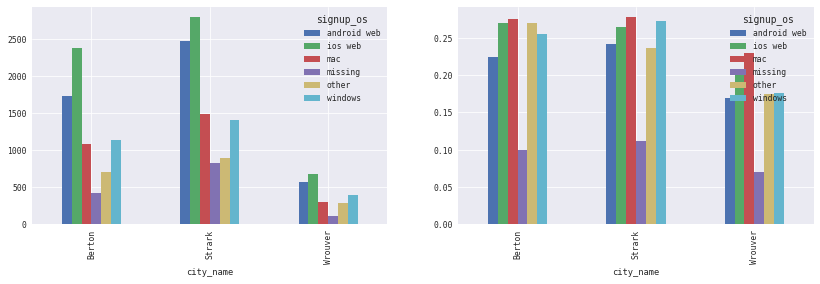

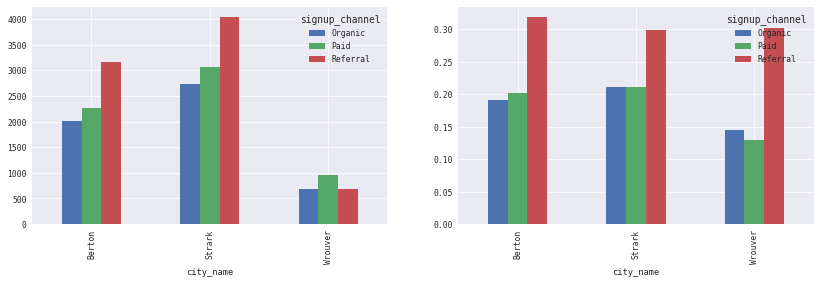

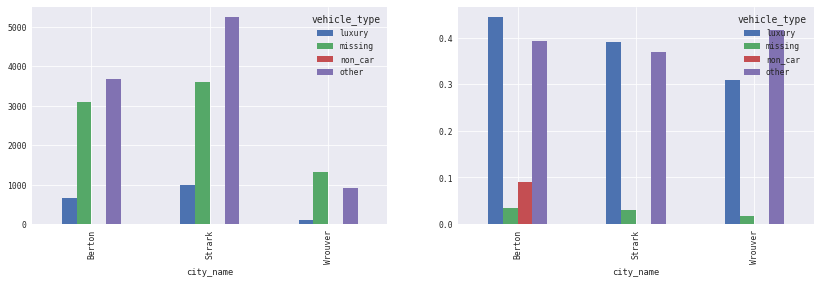

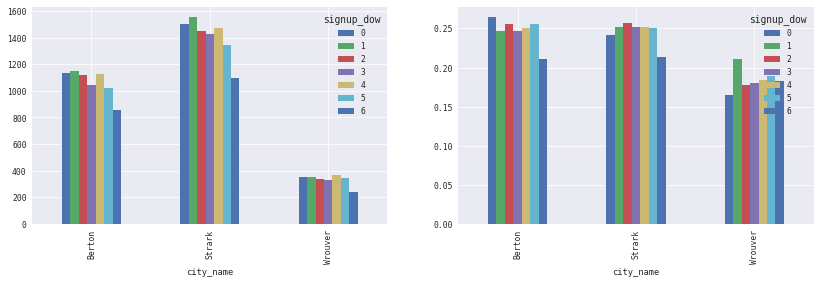

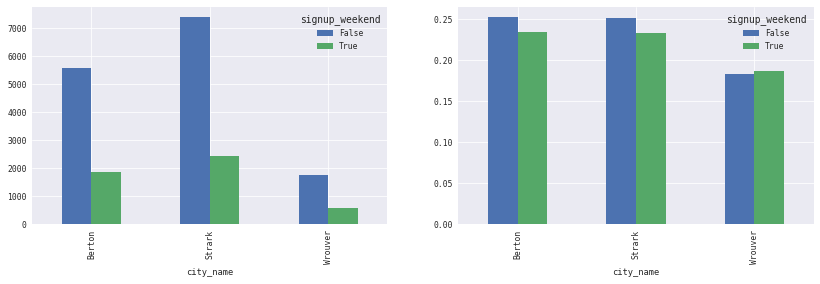

In [227]:
main_col = 'city_name'
cat_col = df_model.columns[df_model.dtypes == 'category']
cat_col_scnd = cat_col.drop('city_name')

cm_g = sns.light_palette("green", as_cmap=True)

for ii in cat_col_scnd:
    plt.figure(figsize=(14, 4))
    ax1 = plt.subplot(121)
    df_model.groupby([ii, main_col]).count()['y'].unstack(level=0).plot(ax=ax1, kind='bar')#, cmap=cm_g)
    ax2 = plt.subplot(122)
    df_model.groupby([ii, main_col]).mean()['y'].unstack(level=0).plot(ax=ax2, kind='bar')#, cmap=cm_g)
    
    # Alternatively, plot bar plot or just the table
    #df_model.groupby(ii).count()['y'].plot('bar', title='total signups')
    #df_model.groupby([main_col, ii]).mean()['y'].unstack(level=0).style.background_gradient(cmap=cm_g)

#### Fig. 2: Histogram of numeric features for both classes

For drivers who did not do addv_after_signup, active rate is 0.030
    For those who did, active rate is 0.388
For drivers who did not do bgc_after_signup, active rate is 0.000
    For those who did, active rate is 0.249


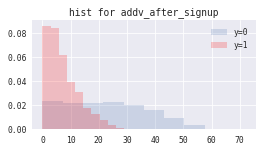

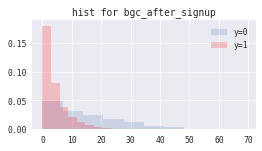

In [228]:
num_col = df_model.columns[df_model.dtypes != 'category']
num_col = num_col.drop('y')
for ii in num_col:#['bgc_after_signup', 'addv_after_signup']:

    df_model_no = df_model[df_model[ii] == 9999]
    df_model_yes = df_model[df_model[ii] != 9999]
    
    print '''For drivers who did not do {}, active rate is {:.3f}
    For those who did, active rate is {:.3f}'''.format(ii, df_model_no.y.mean(), df_model_yes.y.mean())

    df_model_yes_pos = df_model_yes[df_model_yes.y == 1][ii]
    df_model_yes_neg = df_model_yes[df_model_yes.y == 0][ii]
    plt.figure(figsize=(4, 2))
    plt.hist(df_model_yes_neg.values, alpha=0.2, normed=True)
    plt.hist(df_model_yes_pos.values, alpha=0.2, normed=True, color='r', )
    plt.legend(['y=0', 'y=1'])
    plt.title('hist for ' + ii)

### How to impute signup_os

In [229]:
print "fraction of signups taking a first trip for missing os: {}".format(df_model.y[df_model.signup_os == 'missing'].mean())
print "number of missing os: {}".format((df_model.signup_os == 'missing').sum())
print "counts of other os"
df_model.signup_os.value_counts()

## method 1. drop for now since the distribution is too different
#df_model1 = df_model[df_model.signup_os.notnull()].reset_index(drop=True)

## method 2. impute to mode
#df_model.signup_os = df_model.signup_os.fillna('ios web')
#df_model1 = df_model

## method 3. create a new category
#df_model.signup_os = df_model.signup_os.fillna('missing')
#df_model1 = df_model.copy()

fraction of signups taking a first trip for missing os: 0.103905674282
number of missing os: 1357
counts of other os


ios web        5834
android web    4760
windows        2929
mac            2865
other          1869
missing        1357
Name: signup_os, dtype: int64

### (Optional) bin variables to create category vars from num vars

In [230]:
# # Method 1
# bins = [0, 1, 2, 3, 6, 10, 20, 30, 50, 100, 10000]
# labels = ["{0}_{1}".format(i, j) for i, j in zip(bins[:-1], bins[1:])]
# df_model['cat_addv_after_signup'] = pd.cut(df_model.addv_after_signup, bins, right=False, labels=labels)

In [231]:
# # Method 2
# n_san_binned = np.digitize(df_model.addv_after_signup, bins) # which bin is data in
# df_n_san_binned = pd.get_dummies(n_san_binned)
# df_n_san_binned.columns = ['san0', 'san1', 'san2', 'san345', 'sanRest']
# pd.Series(n_san_binned, dtype="category")

### Transform categorical to dummy variables

In [234]:
# Create dummy variables; drop the last dummy created for each categorical variable, as the info is redundant
df1 = df_model
for ii in cat_col:
    df_tmp = pd.get_dummies(df_model[ii], prefix=ii, drop_first=True)
    df1 = pd.concat([df1, df_tmp], axis=1)
    
df1 = df1.drop(cat_col, axis=1).sort_index(axis=1).reset_index(drop=True)

#### Fig. 3 "correlations" of the rest (including dummeis)

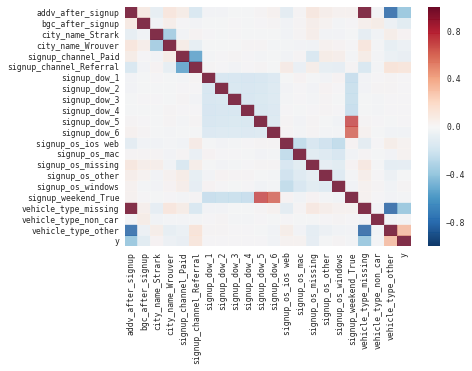

In [241]:
X = df1.sort_index(axis=1).corr()
sns.heatmap(X, alpha=0.8, vmin=-1, vmax=1)
plt.show()

### Scatter plot

In [312]:
df_scatter = df_model.ix[(df_model[num_col] != 9999).all(axis=1), list(num_col) + ['y']]
df_num = df_scatter[num_col]

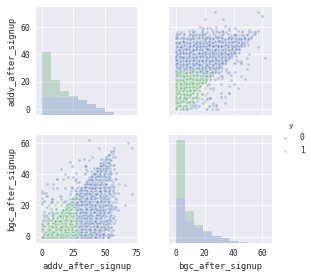

In [302]:
sns.pairplot(df_scatter, hue='y', vars=num_col, size=2,
             plot_kws=dict(alpha=0.3, s=10, edgecolor="w", linewidth=1), 
             diag_kws=dict(alpha=0.3))

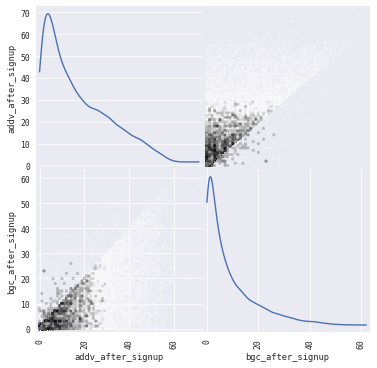

In [313]:
pd.scatter_matrix(df_num, c=df_scatter['y'], alpha=0.2, figsize=(6, 6), diagonal='kde')
plt.show()

## feature selection 

#### Remove correlated features
* get correlation matrix absolute value, only retain large values (>0.9)
* summing up the coefficient for each features, then remove the large ones one by one
* doing this one by one because the correlation will change after removing one

In [314]:
df_corr = df_num.corr().abs()
max_corr = 0.9
df_corr[df_corr <= max_corr] = 0
df_corr.sum().sort_values(ascending=False)

bgc_after_signup     1.0
addv_after_signup    1.0
dtype: float64

#### remove features that don't vary -- all 0 or 1

In [316]:
min_std = 0.1 # mean is around 0.01 for binary vars
features_low_var = df_num.std()[df_num.std() <= min_std].index.tolist()
features_low_var

[]

#### univariate selection

In [347]:
df2 = df1[(df1 != 9999).all(axis=1)].reset_index(drop=True)
X, y, feature_names = ml.get_xy(df2)

In [318]:
#READ this before use
#http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest

from sklearn import feature_selection


# for classification (binary or numeric vars)
chi_results = sorted(zip(feature_selection.chi2(X, y)[1], feature_names))  
max_chi_p_threshold = 0.1
low_chi_features = [ii[1] for ii in chi_results if ii[0] > max_chi_p_threshold]

X_new = feature_selection.SelectKBest(feature_selection.chi2, k=2).fit_transform(df1, df1.y)

# for regression
feature_selection.f_regression(X, y, center=True)


NameError: name 'y' is not defined

In [328]:
SAMPLING!!!!

### Modeling

In [93]:
random_state = 42
n_splits = 10
n_estimators = 100
test_size_ratio = 0.3

"""
model_paras = [{'model': RandomForestClassifier(random_state=random_state, n_estimators=n_estimators), 
                'param_space': {'max_features': np.arange(1, 7, 2), 
                                'min_samples_split': np.arange(1, 11, 3), 
                                'min_samples_leaf': np.arange(1, 11, 3)}}, 
               {'model': GradientBoostingClassifier(random_state=random_state, n_estimators=n_estimators), 
                'param_space': {'learning_rate': [0.3, 0.1, 0.03, 0.01], 'max_depth': range(1, 4)}}
              ]
"""

model_paras = [{'model': RandomForestClassifier(random_state=random_state, n_estimators=n_estimators), 
                'param_space': {'max_features': np.arange(1, 5, 2)}}]

#### Model selection

In [94]:
df3 = df1
X, y, feature_names = ml.get_xy(df3)
index_train, index_test = train_test_split(range(len(y)),                                            
                                           test_size=test_size_ratio, 
                                           random_state=random_state)
X_train, y_train = X[index_train, :], y[index_train]
X_test, y_test = X[index_test, :], y[index_test]

best_learners = []
kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
for model_para in model_paras:    
    clf = GridSearchCV(estimator=model_para['model'], 
                       param_grid=model_para['param_space'], 
                       cv=kf, scoring='roc_auc', n_jobs=-1)
    clf.fit(X_train, y_train)
    best_learners.append((clf.best_score_, clf))

best_learner = sorted(best_learners)[-1][1]

#### Fig. 4 ROC curve

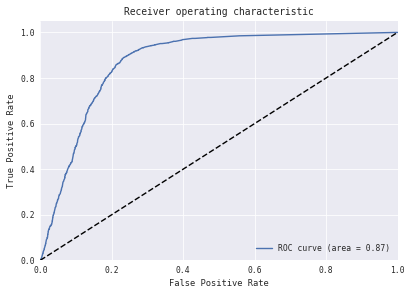

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [101]:
score = best_learner.predict_proba(X_test)[:, 1]
ml.plot_roc(score, y_test)
best_learner.best_estimator_ 

#### Fig. 5 Feature importance

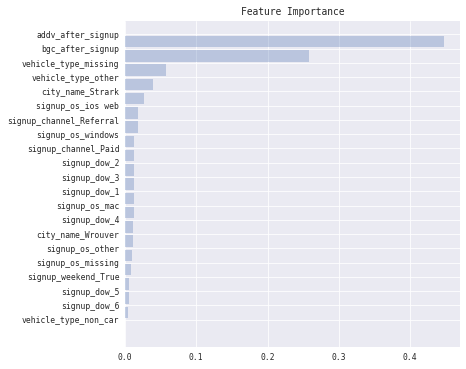

In [100]:
importances = best_learner.best_estimator_.feature_importances_
_, ax = plt.subplots(figsize=(6, 6))
plt.rc('font', size=20)
ml.plot_importance(importances, feature_names, ax)

### Discussion -- predict at the time of signups only

#### Fig. 6 ROC curve of the tentative model

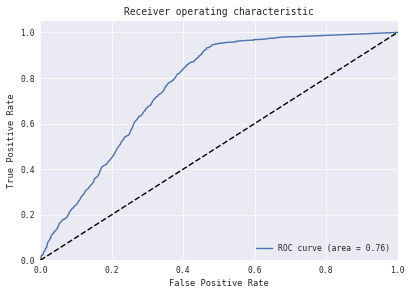

In [58]:
drop_list = ['addv_after_signup', 'bgc_after_signup', u'vehicle_type_non_car', u'vehicle_type_other']
df3 = df1.drop(drop_list, axis=1)
X, y, feature_names = get_xy(df3)
index_train, index_test = train_test_split(range(len(y)),                                            
                                           test_size=test_size_ratio, 
                                           random_state=random_state)
X_train, y_train = X[index_train, :], y[index_train]
X_test, y_test = X[index_test, :], y[index_test]

clf = RandomForestClassifier(random_state=random_state, n_estimators=n_estimators)
clf.fit(X_train, y_train)
score = clf.predict_proba(X_test)[:, 1]
ml.plot_roc(score, y_test)